# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#Import all the required libraries
import  time
import  re
import  glob
from    time import sleep
import  pandas as pd
import  numpy as np
from    skimage import io
import  matplotlib.pyplot as plt
import  random
from    collections import Counter
from    tensorflow.keras.preprocessing.text import Tokenizer
from    tensorflow.keras.preprocessing.sequence import pad_sequences
import  tensorflow as tf
from    tensorflow import keras
from    tensorflow.keras import layers,Model
from    tqdm import tqdm
from    nltk.translate.bleu_score import sentence_bleu
import  socket
import  pickle


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [3]:
in_nimble = False
in_WSL = False
in_tpu = False

host = socket.gethostname()
if('cuda' in host):
    in_nimble = True
    print("In NimbleBox")
if(host == 'LTsuphale-NC2JM'):
    in_WSL = True
    print("In WSL")

In WSL


In [4]:
#Import the dataset and read the image into a seperate variable
# images_path='Images'
# text_file = './captions.txt'
# images_path='/content/drive/MyDrive/TestImages'
# text_file = '/content/drive/MyDrive/captions_small.txt'
# images_path='/content/drive/MyDrive/Images/Images'
# text_file = '/content/drive/MyDrive/captions.txt'
# images_path='./Flickr8K/Images'
# text_file = './Flickr8K/captions.txt'
# images_path='TestImages'
# text_file = './captions_small.txt'
images_path = ''
text_file = ''
# 8, 128, 11828, 118287
total_test_images = 128

if(in_WSL == True):
    images_path='/home/suphale/snehal_bucket/coco/raw-data/train2017/'
if(in_nimble == True):
    images_path='/mnt/disks/user/project/coco/train2017/'

text_file = './lists/captions_' + str(total_test_images) + '.txt'
list_file = './lists/images_' + str(total_test_images) + '.txt'
# Find out total number of images in the images folder
# all_imgs = glob.glob(images_path + '/*.jpg',recursive=True)
# all_imgs = sorted(all_imgs)
# total_num_images = len(all_imgs)
# print("The total images present in the images folder: {}".format(total_num_images))


In [5]:
all_imgs = [images_path + line.rstrip() for line in open(list_file)]
all_imgs = sorted(all_imgs)
total_num_images = len(all_imgs)
print("The total images present in the dataset: {}".format(total_num_images))


The total images present in the dataset: 128


In [6]:
#Visualise both the images & text present in the dataset
print("The total images present in the dataset: {}".format(total_num_images))
num_lines = sum(1 for line in open(text_file))
print("The total number of lines in the caption file: {}".format(num_lines))


The total images present in the dataset: 128
The total number of lines in the caption file: 641


In [7]:
# define a function to clean text data
def extract_jpg_caption(line):
    char_filter = r"[^\w]"

    jpg_path = None
    caption = None

    jpg_position = line.find(".jpg")
    if(jpg_position != -1):
        jpg_path = images_path + '/' + line[:jpg_position+4]

        caption = line[jpg_position+5:].strip()

        # convert words to lower case
        caption = caption.lower()

        # split into words
        words = caption.split()

        # strip whitespace from all words
        words = [word.strip() for word in words]

        # join back words to get document
        caption = " ".join(words)

        # remove unwanted characters
        caption = re.sub(char_filter, " ", caption)

        # remove unwanted characters
        caption = re.sub(r"\.", " ", caption)

        # replace multiple whitespaces with single whitespace
        caption = re.sub(r"\s+", " ", caption)

        # strip whitespace from document
        caption = caption.strip()

        caption = '<start> ' + caption + ' <end>'

    return jpg_path, caption

In [8]:
#store all the image id here
all_img_id= [] 
#store all the image path here
all_img_vector=[]
#store all the captions here
annotations= [] 
# list of all captions in word list format
annotations_word_list = []

In [9]:
def load_doc(filename):
    #your code here
    file  = open(filename, 'r') 
    Lines = file.readlines() 
    
    text = ""
    count = 0
    for line in Lines:
        jpg_path, caption = extract_jpg_caption(line)
        if(jpg_path != None):
            all_img_id.append(count)
            all_img_vector.append(jpg_path)
            annotations.append(caption)
            word_list = caption.split()
            annotations_word_list.append(word_list)
            text += " " + caption
            count += 1
    file.close()
    return text

In [10]:
#Import the dataset and read the text file into a seperate variable
doc = load_doc(text_file)
print(doc[:300])

 <start> a large brown couch sitting next to a fireplace <end> <start> a living room has a sofa and pictures on the walls <end> <start> a beige sectional sofa next to a fireplace and a mirror <end> <start> a living room with a couch fireplace and wood floors <end> <start> an image of a living room s


In [11]:
a = set()
for x in annotations_word_list:
    for y in x:
        a.add(y)
print("Total words present in the captions = %d" % (len(a)))

Total words present in the captions = 1094


In [12]:
annotations[:2]

['<start> a large brown couch sitting next to a fireplace <end>',
 '<start> a living room has a sofa and pictures on the walls <end>']

Randomly pick an image from the data and show its corresponding caption


In [13]:
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_vector)))
total_images = len(all_img_vector)

Total captions present in the dataset: 640
Total images present in the dataset: 640


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [14]:
# create the tokenizer

# your code here
max_tokenized_words = 20000

tokenizer = Tokenizer(num_words=max_tokenized_words+1,oov_token='<unknown>')
tokenizer.fit_on_texts(annotations_word_list)


In [15]:
# Create word-to-index and index-to-word mappings.
VOCABULARY_SIZE = len(tokenizer.word_index) + 1
print('Vocabulary Size: {}'.format(VOCABULARY_SIZE))

# print("index of dog = %d" % (tokenizer.word_index['dog']))
# print("word corresponding to index 10 = %s" % (tokenizer.index_word[10]))


Vocabulary Size: 1096


In [16]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

MAX_SEQ_LENGTH = 25

cap_vector = annotations_word_list
Y_encoded = tokenizer.texts_to_sequences(cap_vector)
cap_vector_encoded_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")



## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [17]:
#write your code here
batch_size = 32
def read_image(image_path,label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = tf.cast(image, tf.float32)
    image /= 127.5
    image -= 1.
    return image, label


## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


split the data into train, validation and final test sets

In [18]:
from sklearn.model_selection import train_test_split

# split the data into train, validation and final test sets
img_train, final_img_test, cap_train, final_cap_test = train_test_split(all_img_vector, cap_vector_encoded_padded, test_size=0.01, random_state=42)
img_train, img_test, cap_train, cap_test = train_test_split(img_train, cap_train, test_size=0.2, random_state=42)

total_training_images = len(img_train)
total_test_images = len(img_test)
total_final_testing_images = len(final_img_test)
print("Total Images for training=%d" % (total_training_images))
print("Total Images for testing (validation)=%d" % (total_test_images))
print("Total Images for final random testing=%d" % (total_final_testing_images))



Total Images for training=506
Total Images for testing (validation)=127
Total Images for final random testing=7


In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((img_train, cap_train))
test_dataset = tf.data.Dataset.from_tensor_slices((img_test, cap_test))
final_test_dataset = tf.data.Dataset.from_tensor_slices((final_img_test, final_cap_test))


In [20]:
#write your code here
train_dataset = train_dataset.map(read_image)
train_dataset.shuffle(buffer_size=1024,reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset.map(read_image)
test_dataset.shuffle(buffer_size=1024,reshuffle_each_iteration=True)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

A utility function to display image retrieved from a dataset and its corresponding caption

In [21]:
# A utility function to display image retrieved from a dataset and its corresponding caption
def show_image_caption_from_dataset(image,label):
    plt.imshow(image)
    for x in label.numpy():
        if(x != 0):
            print(tokenizer.index_word[x], end =" ")


Check that the data retrieved from dataset is in correct format

In [22]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
# (batch_size, 299, 299, 3)
print(sample_img_batch.shape) 
# (batch_size, max_len)
print(sample_cap_batch.shape) 


(32, 299, 299, 3)
(32, 25)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 299, 299, 3)
(32, 25)
<start> closed toilet next to messy bathtub in white tiled bathroom <end> 

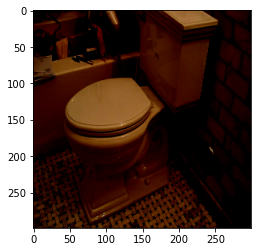

In [23]:
sample_img_batch, sample_cap_batch = next(iter(test_dataset))
# (batch_size, 299, 299, 3)
print(sample_img_batch.shape) 
# (batch_size, max_len)
print(sample_cap_batch.shape) 
# show_image_caption_from_dataset(sample_img_batch[0],sample_cap_batch[0])

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [24]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

# write code here to get the input of the image_model
new_input = image_model.input 
# write code here to get the output of the image_model
hidden_layer = image_model.output 

#build the final model using both input & output layer
image_features_extract_model = keras.Model(inputs=new_input, outputs=hidden_layer)

In [29]:
# for layer in image_model.layers[:-1]:
#     print(layer)

In [25]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [26]:
from tensorflow.keras import  losses
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [27]:
#write your code here
batch_size = 32
def my_read_image(image_path,label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = tf.cast(image, tf.float32)
    image /= 127.5
    image -= 1.
    return image, image

ae_train_dataset = tf.data.Dataset.from_tensor_slices((img_train, img_train))
# ae_test_dataset = tf.data.Dataset.from_tensor_slices((img_test, img_test))
# ae_train_dataset = ae_train_dataset.shuffle(buffer_size=1024).batch(32)

ae_train_dataset = ae_train_dataset.map(my_read_image)
# ae_train_dataset.shuffle(buffer_size=1024,reshuffle_each_iteration=True)
# ae_train_dataset = ae_train_dataset.batch(batch_size)
# ae_train_dataset = ae_train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# print(type(ae_train_dataset))
# print(str(ae_train_dataset.shape()))

autoencoder.fit(ae_train_dataset,epochs=10)

Epoch 1/10


ValueError: in user code:

    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:756 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1198 mean_squared_error
        return K.mean(math_ops.squared_difference(y_pred, y_true), axis=-1)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py:10251 squared_difference
        "SquaredDifference", x=x, y=y, name=name)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:750 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:592 _create_op_internal
        compute_device)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3536 _create_op_internal
        op_def=op_def)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:2016 __init__
        control_input_ops, op_def)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 28 and 299 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](autoencoder/sequential_1/reshape/Reshape, IteratorGetNext:1)' with input shapes: [299,28,28], [299,299,3].


In [ ]:
# write your code to extract features from each image in the dataset
def extract_image_features(sample_img_batch):
    features = image_features_extract_model(sample_img_batch)
    features = tf.reshape(features, [sample_img_batch.shape[0],8*8, 2048])
    return features


In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
sample_img_batch = extract_image_features(sample_img_batch)
# (batch_size, 8*8, 2048)
print("sample_img_batch.shape after extract_image_features",sample_img_batch.shape)  
# (batch_size,40)
print("sample_cap_batch.shape after extract_image_features",sample_cap_batch.shape) 

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(test_dataset))
sample_img_batch = extract_image_features(sample_img_batch)
# (batch_size, 8*8, 2048)
print("sample_img_batch.shape after extract_image_features",sample_img_batch.shape)  
# (batch_size,40)
print("sample_cap_batch.shape after extract_image_features",sample_cap_batch.shape) 

## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [ ]:
embedding_dim = 256 
units = 512
vocab_size = max_tokenized_words + 1
train_num_steps = total_training_images //batch_size #len(total train images) // BATCH_SIZE
test_num_steps = total_test_images //batch_size #len(total test images) // BATCH_SIZE

### Encoder

In [ ]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        # build your Dense layer with relu activation
        self.dense = tf.keras.layers.Dense(embed_dim, activation='relu')
        
    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = self.dense(features)
        return features    

In [ ]:
encoder=Encoder(embedding_dim)

### Attention model

In [ ]:
from tensorflow.keras.activations import tanh
from tensorflow.keras.activations import softmax

class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.units=units
        # build your Dense layer
        self.W1 = tf.keras.layers.Dense(units)
        # build your Dense layer
        self.W2 = tf.keras.layers.Dense(units)
        # build your final Dense layer with unit 1
        # self.V = tf.keras.layers.Dense(1, activation='softmax')
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        
        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # build your score funciton to shape: (batch_size, 8*8, units)
        score = tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        # extract your attention weights with shape: (batch_size, 8*8, 1)
        score = self.V(score)
        attention_weights = softmax(score, axis=1)

        # shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features
        # reduce the shape to (batch_size, embedding_dim)
        # context_vector = tf.reduce_sum(context_vector, axis=1)
        context_vector = tf.reduce_mean(context_vector, axis=1)

        return context_vector, attention_weights        

### Decoder

In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        # iniitalise your Attention model with units
        self.attention = Attention_model(self.units)
        # build your Embedding layer
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        # build your Dense layer
        self.d1 = tf.keras.layers.Dense(self.units)
        # build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)


    def call(self,x,features, hidden):
        #create your context vector & attention weights from attention model
        context_vector, attention_weights = self.attention(features, hidden)
        # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = self.embed(x)
        # Concatenate your input with the context vector from attention layer. 
        # Shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        # Extract the output & hidden state from GRU layer. 
        # Output shape : (batch_size, max_length, hidden_size)
        output, state = self.gru(embed)
        output = self.d1(output)
        # shape : (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2])) 
        # shape : (batch_size * max_length, vocab_size)
        output = self.d2(output)

        return output, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "./ckpt"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
# @tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    img_tensor = extract_image_features(img_tensor)

    with tf.GradientTape() as tape:
        # Get the fixed length vector of Encoder-Decoder model
        features = encoder(img_tensor)
        # Loop through for max_length times
        for i in range(1, target.shape[1]):
            # Get predictions from the decoder
            # print("dec_input=%s features=%s hidden=%s" % (str(type(dec_input)), str(type(features)), str(type(hidden))))
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # Get the next target vector as dec_input
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
# @tf.function
def test_step(img_tensor, target):
    #write your code here to do the testing steps
    loss = 0

    hidden = decoder.init_state(batch_size=target.shape[0])
    img_tensor = extract_image_features(img_tensor)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        loss += loss_function(target[:, i], predictions)

        dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    return loss, total_loss

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps
    
    return avg_test_loss

In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 10

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    

    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [ ]:
def evaluate(image):
    attention_features_shape = 64
    attention_plot = np.zeros((MAX_SEQ_LENGTH, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    # process the input image to desired format before extracting features
    temp_input = tf.expand_dims(read_image(image,[])[0], 0) 
    # Extract features using our feature extraction model
    img_tensor_val = extract_image_features(temp_input)
    # img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # extract the features by passing the input to encoder
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(MAX_SEQ_LENGTH):
        # get the output from decoder
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        #extract the predicted id(embedded value) which carries the max value
        predicted_id = tf.argmax(tf.transpose(predictions))
        predicted_id = predicted_id.numpy()[0]
        # map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [ ]:
def beam_evaluate(image, beam_index = 0): #your value for beam index):

    final_caption = "ToDo"
    #write your code to evaluate the result using beam search
                  
    return final_caption


In [ ]:
from PIL import Image
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot((len_cap//2)+1, (len_cap//2)+1, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
final_img_test[0]

In [ ]:
import time
rid = np.random.randint(0, total_final_testing_images)
test_image = final_img_test[rid]
# test_image = './Images/413231421_43833a11f5.jpg'
# test_image = '/content/drive/MyDrive/TestImages/3637013_c675de7705.jpg'

real_caption = final_cap_test[rid]
# real_caption = '<start> A couple stands close at the water edge <end>'
# real_caption = '<start> black dog is digging in the snow <end>'
real_caption = ' '.join([tokenizer.index_word[i] for i in final_cap_test[rid] if i not in [0]])

t0= time.perf_counter()
result, attention_plot,pred_test = evaluate(test_image)
t1 = time.perf_counter() - t0
print("Time elapsed: ", t1)

real_caption=filt_text(real_caption)      

pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=[1]) #set your weights)
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [ ]:
captions=beam_evaluate(test_image)
print(captions)

In [ ]:
# image_features_extract_model.summary()

In [ ]:
encoder.summary()

In [ ]:
decoder.summary()

In [ ]:
# saving
with open('temp_model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#decoder.save('MyModel',save_format='tf')
model_json = image_features_extract_model.to_json()
with open("temp_model/image_features_extract_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
image_features_extract_model.save_weights("temp_model/image_features_extract_model.h5")
print("Saved image_features_extract_model to disk")

decoder.save_weights("temp_model/decoder.h5")
encoder.save_weights("temp_model/encoder.h5")


In [ ]:
# loading
with open('temp_model/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

#Reading the model from JSON file
with open('temp_model/image_features_extract_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
model_j = tf.keras.models.model_from_json(json_savedModel)
model_j.load_weights('temp_model/image_features_extract_model.h5')


In [ ]:
decoder.load_weights("temp_model/decoder.h5")
encoder.load_weights("temp_model/encoder.h5")


In [ ]:
import time
test_image = './413231421_43833a11f5.jpg'
# test_image = '/content/drive/MyDrive/TestImages/3637013_c675de7705.jpg'

# real_caption = final_cap_test[rid]
real_caption = '<start> A couple stands close at the water edge <end>'
# real_caption = '<start> black dog is digging in the snow <end>'
# real_caption = ' '.join([tokenizer.index_word[i] for i in final_cap_test[rid] if i not in [0]])

t0= time.perf_counter()
result, attention_plot,pred_test = evaluate(test_image)
t1 = time.perf_counter() - t0
print("Time elapsed: ", t1)

real_caption=filt_text(real_caption)      

pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=[1]) #set your weights)
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)